<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/tony_nn_smaller_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import functools
import operator

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
from jax.experimental import stax
from jax.experimental import optimizers
from jax.config import config
config.update("jax_enable_x64", True)

tf.random.set_seed(42)

[0 0 0 1 1 0 0 1 0 1]


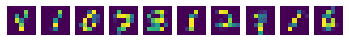

[0 0 0 1 1 1 0 1 0 0]


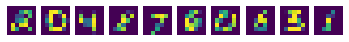

[1 1 0 0 1 1 0 1 1 1]


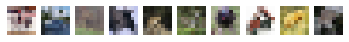

[1 0 1 1 1 0 1 0 0 0]


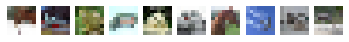

In [ ]:
def downsample_imgs(imgs, image_width):
    return tf.image.resize(
        tf.convert_to_tensor(imgs),
        size=[image_width, image_width],
        method=tf.image.ResizeMethod.BILINEAR,
        preserve_aspect_ratio=True,
        antialias=False,
    ).numpy()

def get_np_data(
    name, # "mnist" or "cifar10"
    split,
    binary_labels=True,
    flatten=False,
    image_width=None,
):
    """
    name: e.g. "mnist", "cifar10". See
          https://www.tensorflow.org/datasets/catalog/overview for more details.
    split: See https://www.tensorflow.org/datasets/splits
    """

    xs, ys = operator.itemgetter('image', 'label')(
        tfds.as_numpy(
            tfds.load(
                name=name,
                split=split,
                batch_size=-1,
                data_dir="./data",
            )
        )
    )

    xs = xs.astype(np.float64)
    xs /= 255.0 # normalize

    if binary_labels:
        n_classes = ys.max() + 1
        ys = (ys >= (n_classes // 2)).astype(np.int)

    if image_width is not None:
        xs = downsample_imgs(xs, image_width)

    if flatten:
        xs = xs.reshape((len(xs), -1))

    return xs, ys

mnist_train_np = get_np_data(name="mnist", split="train[:2000]", image_width=7)
mnist_test_np = get_np_data(name="mnist", split="test[:2000]", image_width=7)
cifar_train_np = get_np_data(name="cifar10", split="train[:2000]", image_width=8)
cifar_test_np = get_np_data(name="cifar10", split="test[:2000]", image_width=8)

for data in [mnist_train_np, mnist_test_np, cifar_train_np, cifar_test_np]:
    xs, ys = data
    print(ys[:10])
    for i, x in enumerate(xs[:10]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(x.squeeze())
        plt.axis('off')
    plt.show();

In [ ]:
def np_data_to_tfds(np_data, batch_size, shuffle_seed=42):
    return (
        tf.data.Dataset.from_tensor_slices(np_data)
        .cache()
        .shuffle(
            buffer_size=len(np_data[0]),
            seed=shuffle_seed,
            reshuffle_each_iteration=False)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

mnist_train_ds = np_data_to_tfds(mnist_train_np, batch_size=200)
mnist_test_ds =  np_data_to_tfds(mnist_test_np,  batch_size=200)
cifar_train_ds = np_data_to_tfds(cifar_train_np, batch_size=200)
cifar_test_ds =  np_data_to_tfds(cifar_test_np,  batch_size=200)

# NN utilities

In [ ]:
def l2_squared(pytree):
    leaves, _ = jax.tree_flatten(pytree)
    return sum(jnp.vdot(x, x) for x in leaves)

@functools.partial(jax.jit, static_argnums=(0,))
def nll_mean_minibatch(model_fn, model_params, xs, ys):
    """
    Returns mean negative log likelihood
    
    model_params: passed to model_fn
    xs.shape: (batch_size, ...)
    ys.shape: (batch_size, ),
    """
    preds = model_fn(model_params, xs)
    log_probs = jnp.take_along_axis(preds, jnp.expand_dims(ys, axis=1), axis=1)
    return -jnp.mean(log_probs)

@functools.partial(jax.jit, static_argnums=(0,))
def loss_minibatch(model_fn, model_params, l2_lam_over_n, xs, ys):
    nll_mean = nll_mean_minibatch(model_fn, model_params, xs, ys)
    l2_val = l2_squared(model_params)
    return nll_mean + l2_val * (l2_lam_over_n / 2.0)

def loss_ds(model_fn, model_params, l2_lam_over_n, ds):
    """
    model_params: passed to model_fn
    ds: a tf.Dataset
    """
    # Perform a weighted average
    loss_total, num_total = 0, 0
    for xs, ys in tfds.as_numpy(ds):
        batch_size = len(ys)
        
        batch_loss = loss_minibatch(
            model_fn, model_params, l2_lam_over_n, xs, ys)
        
        loss_total += batch_size * batch_loss
        num_total += batch_size
    
    return loss_total / num_total
    
def accuracy_ds(model_fn, model_params, ds):
    """
    model_params: passed to model_fn
    ds: a tf.Dataset
    """
    num_correct, num_total = 0, 0
    for xs, ys in tfds.as_numpy(ds):
        batch_size = len(ys)
        
        preds = model_fn(model_params, xs)
        pred_targets = jnp.argmax(preds, axis=1)
        
        num_correct += jnp.sum(pred_targets == ys)
        num_total += batch_size
    
    return num_correct / num_total

def train_model(
    model_init,
    model_fn,
    ds_train,
    step_size_schedule={0: 0.1},
    num_epochs=64,
    l2_lam_over_n=0.1,
    rng=jax.random.PRNGKey(42),
    verbose=False,
):
    """
    model_fn: should return log probabilities
    ds_train: a tf.Dataset
    """
    
    @functools.partial(jax.jit, static_argnums=(0,))
    def train_step(opt_update, opt_state, xs, ys):
        model_params = get_params(opt_state)
        loss, grad = (
            jax.value_and_grad(loss_minibatch, argnums=1)
                              (model_fn, model_params, l2_lam_over_n, xs, ys)
        )
        return opt_update(0, grad, opt_state), loss
    
    

    # Initialization
    _, init_params = model_init(
        input_shape=(-1,) + tuple(ds_train.element_spec[0].shape[1:]),
        rng=rng
    )
    
    # Train loop
    best_params = init_params
    best_train_loss = loss_ds(model_fn, best_params, l2_lam_over_n, ds_train)
    train_losses = []
    for epoch in (tqdm(range(num_epochs)) if verbose else range(num_epochs)):
        if epoch in step_size_schedule:
            opt_init, opt_update, get_params = (
                #optimizers.sgd(step_size=step_size_schedule[epoch])
                optimizers.momentum(step_size=step_size_schedule[epoch], mass=0.9)
                #optimizers.adam(step_size=step_size_schedule[epoch])
            )
            opt_state = opt_init(best_params)
        
        train_loss_tot, num_xs_tot = 0, 0
        for xs, ys in tfds.as_numpy(ds_train):    
            opt_state, cur_loss = train_step(opt_update, opt_state, xs, ys)
            
            train_loss_tot += cur_loss * len(xs)
            num_xs_tot += len(xs)
            
        train_loss = train_loss_tot / num_xs_tot
        train_losses.append(train_loss)
        
        if train_loss < best_train_loss:
            best_params = get_params(opt_state)
            best_train_loss = train_loss
        
    return best_params, train_losses

# FC NN

In [ ]:
fc_model_init, fc_model_fn = stax.serial(
    stax.Flatten,
    stax.Dense(20), stax.Relu,
    stax.Dense(20), stax.Relu,
    stax.Dense(20), stax.Relu,
    stax.Dense(2), stax.LogSoftmax
)

In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    fc_model_params, train_losses = train_model(
        model_init=fc_model_init,
        model_fn=fc_model_fn,
        ds_train=mnist_train_ds,
        step_size_schedule={
            0: 0.01,
            300: 0.001
        },
        num_epochs=400,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist train acc: {accuracy_ds(fc_model_fn, fc_model_params, mnist_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist test  acc: {accuracy_ds(fc_model_fn, fc_model_params, mnist_test_ds)}")

#plt.plot(train_losses);

l2_lam_over_n=     1 fc-nn train acc: 0.514
l2_lam_over_n=     1 fc-nn test  acc: 0.5115
l2_lam_over_n=   0.1 fc-nn train acc: 0.514
l2_lam_over_n=   0.1 fc-nn test  acc: 0.5115
l2_lam_over_n=  0.01 fc-nn train acc: 0.958
l2_lam_over_n=  0.01 fc-nn test  acc: 0.8865
l2_lam_over_n= 0.001 fc-nn train acc: 0.9915
l2_lam_over_n= 0.001 fc-nn test  acc: 0.872
l2_lam_over_n=0.0001 fc-nn train acc: 0.9855
l2_lam_over_n=0.0001 fc-nn test  acc: 0.8765
l2_lam_over_n=     0 fc-nn train acc: 0.9855
l2_lam_over_n=     0 fc-nn test  acc: 0.8785
CPU times: user 1min 14s, sys: 9.76 s, total: 1min 23s
Wall time: 1min 10s


In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    fc_model_params, train_losses = train_model(
        model_init=fc_model_init,
        model_fn=fc_model_fn,
        ds_train=cifar_train_ds,
        step_size_schedule={
            0: 0.01,
            500: 0.001
        },
        num_epochs=800,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar train acc: {accuracy_ds(fc_model_fn, fc_model_params, cifar_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar test  acc: {accuracy_ds(fc_model_fn, fc_model_params, cifar_test_ds)}")

l2_lam_over_n=     1 fc-nn train acc: 0.5075
l2_lam_over_n=     1 fc-nn test  acc: 0.495
l2_lam_over_n=   0.1 fc-nn train acc: 0.5075
l2_lam_over_n=   0.1 fc-nn test  acc: 0.495
l2_lam_over_n=  0.01 fc-nn train acc: 0.9285
l2_lam_over_n=  0.01 fc-nn test  acc: 0.5785
l2_lam_over_n= 0.001 fc-nn train acc: 0.991
l2_lam_over_n= 0.001 fc-nn test  acc: 0.599
l2_lam_over_n=0.0001 fc-nn train acc: 0.9945
l2_lam_over_n=0.0001 fc-nn test  acc: 0.5815
l2_lam_over_n=     0 fc-nn train acc: 0.996
l2_lam_over_n=     0 fc-nn test  acc: 0.584
CPU times: user 2min 27s, sys: 20.4 s, total: 2min 47s
Wall time: 2min 20s


# Convolutional NN

### Flatten

In [ ]:
cnn_flat_model_init, cnn_flat_model_fn = stax.serial(
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.Flatten,
    stax.Dense(2), stax.LogSoftmax
)

In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    cnn_flat_model_params, train_losses = train_model(
        model_init=cnn_flat_model_init,
        model_fn=cnn_flat_model_fn,
        ds_train=mnist_train_ds,
        step_size_schedule={
            0: 0.01,
            200: 0.001
        },
        num_epochs=300,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist train acc: {accuracy_ds(cnn_flat_model_fn, cnn_flat_model_params, mnist_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist test  acc: {accuracy_ds(cnn_flat_model_fn, cnn_flat_model_params, mnist_test_ds)}")

l2_lam_over_n=      1 fc-nn train acc: 0.514
l2_lam_over_n=      1 fc-nn test  acc: 0.5115
l2_lam_over_n=    0.1 fc-nn train acc: 0.514
l2_lam_over_n=    0.1 fc-nn test  acc: 0.5115
l2_lam_over_n=   0.01 fc-nn train acc: 0.938
l2_lam_over_n=   0.01 fc-nn test  acc: 0.8935
l2_lam_over_n=  0.001 fc-nn train acc: 0.9935
l2_lam_over_n=  0.001 fc-nn test  acc: 0.895
l2_lam_over_n= 0.0001 fc-nn train acc: 0.996
l2_lam_over_n= 0.0001 fc-nn test  acc: 0.889
l2_lam_over_n=      0 fc-nn train acc: 0.9945
l2_lam_over_n=      0 fc-nn test  acc: 0.895
CPU times: user 1min 4s, sys: 9.16 s, total: 1min 14s
Wall time: 1min 5s


In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    cnn_flat_model_params, train_losses = train_model(
        model_init=cnn_flat_model_init,
        model_fn=cnn_flat_model_fn,
        ds_train=cifar_train_ds,
        step_size_schedule={
            0: 0.01,
            400: 0.001
        },
        num_epochs=500,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar train acc: {accuracy_ds(cnn_flat_model_fn, cnn_flat_model_params, cifar_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar test  acc: {accuracy_ds(cnn_flat_model_fn, cnn_flat_model_params, cifar_test_ds)}")

l2_lam_over_n=      1 fc-nn train acc: 0.5075
l2_lam_over_n=      1 fc-nn test  acc: 0.495
l2_lam_over_n=    0.1 fc-nn train acc: 0.5075
l2_lam_over_n=    0.1 fc-nn test  acc: 0.495
l2_lam_over_n=   0.01 fc-nn train acc: 0.7205
l2_lam_over_n=   0.01 fc-nn test  acc: 0.608
l2_lam_over_n=  0.001 fc-nn train acc: 0.999
l2_lam_over_n=  0.001 fc-nn test  acc: 0.583
l2_lam_over_n= 0.0001 fc-nn train acc: 1.0
l2_lam_over_n= 0.0001 fc-nn test  acc: 0.5775
l2_lam_over_n=      0 fc-nn train acc: 1.0
l2_lam_over_n=      0 fc-nn test  acc: 0.559
CPU times: user 1min 45s, sys: 14.4 s, total: 1min 59s
Wall time: 1min 41s


### Global average pool

In [ ]:
cnn_gap_model_init, cnn_gap_model_fn = stax.serial(
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.Conv(20, (3, 3)), stax.Relu,
    stax.AvgPool((1,1)),
    stax.Flatten,
    stax.Dense(2), stax.LogSoftmax
)

In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    cnn_gap_model_params, train_losses = train_model(
        model_init=cnn_gap_model_init,
        model_fn=cnn_gap_model_fn,
        ds_train=mnist_train_ds,
        step_size_schedule={
            0: 0.01,
            400: 0.001
        },
        num_epochs=500,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist train acc: {accuracy_ds(cnn_gap_model_fn, cnn_gap_model_params, mnist_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn mnist test  acc: {accuracy_ds(cnn_gap_model_fn, cnn_gap_model_params, mnist_test_ds)}")

l2_lam_over_n=      1 fc-nn mnist train acc: 0.514
l2_lam_over_n=      1 fc-nn mnist test  acc: 0.5115
l2_lam_over_n=    0.1 fc-nn mnist train acc: 0.514
l2_lam_over_n=    0.1 fc-nn mnist test  acc: 0.5115
l2_lam_over_n=   0.01 fc-nn mnist train acc: 0.959
l2_lam_over_n=   0.01 fc-nn mnist test  acc: 0.8945
l2_lam_over_n=  0.001 fc-nn mnist train acc: 1.0
l2_lam_over_n=  0.001 fc-nn mnist test  acc: 0.8925
l2_lam_over_n= 0.0001 fc-nn mnist train acc: 1.0
l2_lam_over_n= 0.0001 fc-nn mnist test  acc: 0.8945
l2_lam_over_n=      0 fc-nn mnist train acc: 1.0
l2_lam_over_n=      0 fc-nn mnist test  acc: 0.893
CPU times: user 1min 42s, sys: 13.1 s, total: 1min 55s
Wall time: 1min 37s


l2_lam_over_n=      1 fc-nn cifar train acc: 0.5075
l2_lam_over_n=      1 fc-nn cifar test  acc: 0.495
l2_lam_over_n=    0.1 fc-nn cifar train acc: 0.5075
l2_lam_over_n=    0.1 fc-nn cifar test  acc: 0.495
l2_lam_over_n=   0.01 fc-nn cifar train acc: 0.721
l2_lam_over_n=   0.01 fc-nn cifar test  acc: 0.6075
l2_lam_over_n=  0.001 fc-nn cifar train acc: 1.0
l2_lam_over_n=  0.001 fc-nn cifar test  acc: 0.569
l2_lam_over_n= 0.0001 fc-nn cifar train acc: 1.0
l2_lam_over_n= 0.0001 fc-nn cifar test  acc: 0.576
l2_lam_over_n=      0 fc-nn cifar train acc: 1.0
l2_lam_over_n=      0 fc-nn cifar test  acc: 0.5805
CPU times: user 1min 47s, sys: 14.6 s, total: 2min 1s
Wall time: 1min 43s


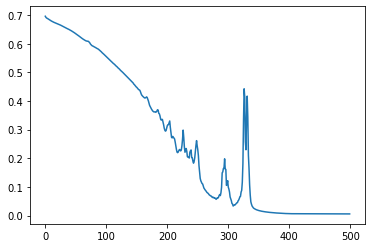

In [ ]:
%%time
for l2_lam_over_n in [1, 1e-1, 1e-2, 1e-3, 1e-4, 0]:
    cnn_gap_model_params, train_losses = train_model(
        model_init=cnn_gap_model_init,
        model_fn=cnn_gap_model_fn,
        ds_train=cifar_train_ds,
        step_size_schedule={
            0: 0.01,
            400: 0.001
        },
        num_epochs=500,
        l2_lam_over_n=l2_lam_over_n,
        verbose=False,
        rng=jax.random.PRNGKey(1),
    );

    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar train acc: {accuracy_ds(cnn_gap_model_fn, cnn_gap_model_params, cifar_train_ds)}")
    print(f"l2_lam_over_n={l2_lam_over_n:7} fc-nn cifar test  acc: {accuracy_ds(cnn_gap_model_fn, cnn_gap_model_params, cifar_test_ds)}")